# Echo State Network Training
## MNIST Dataset
## Exploits GPUs if MPS or CUDA is available
### final_representation_np : representation after sparsity and learning; see file final_representation.npy
### sparse_representation_np : representtaion after sparsity, before learning; see file sparse_representation.npy
### Z_tr_np : representation before sparsity; see file Z_tr.npy   


In [1]:
import time
import numpy as np

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torch import optim


In [2]:
start = time.time()

In [3]:
class ESN(nn.Module):
    
    def __init__(self,N,N_in,N_av,alpha,rho,gamma):
        super().__init__()
        
        #device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


        self.N=N
        self.alpha=alpha
        self.rho=rho
        self.N_av=N_av
        self.N_in=N_in
        self.gamma=gamma
        
        diluition=1-N_av/N
        W=np.random.uniform(-1,1,[N,N])
        W=W*(np.random.uniform(0,1,[N,N])>diluition)
        eig=np.linalg.eigvals(W)
        self.W=torch.from_numpy(self.rho*W/(np.max(np.absolute(eig)))).float()
        self.W = torch.from_numpy(self.rho * W / (np.max(np.absolute(eig)))).float().to(device)
     
        
        self.x=[]
        
        if self.N_in==1:
            
            self.W_in=2*np.random.randint(0,2,[self.N_in,self.N])-1
            self.W_in = torch.from_numpy(self.W_in * self.gamma).float().to(device)
            
        else:
            
            self.W_in=np.random.randn(self.N_in,self.N)
            self.W_in = torch.from_numpy(self.W_in * self.gamma).float().to(device)
        
    def Reset(self,s):

        batch_size=np.shape(s)[0]
        self.x = torch.zeros([batch_size, self.N], device=self.W.device)

        
    def ESN_1step(self,s):
        
        self.x=(1-self.alpha)*self.x+self.alpha*torch.tanh(torch.matmul(s,self.W_in)+torch.matmul(self.x,self.W))
 

    def ESN_response(self,Input):
        
        T=Input.shape[2]
        X = torch.zeros(Input.shape[0], self.N, T, device=self.W.device)

        
        self.Reset(Input[:,0])
        
        
        for t in range(T):
    
            self.ESN_1step(Input[:,:,t])
            X[:,:,t]=torch.clone(self.x)

        return X
        

## Load the data

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Data Preparation

In [5]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
X_te = mnist_testset.data.to(device)    ## Test set images
y_te = mnist_testset.targets.to(device) ## Test set labels


N_o=10                                ## Number of output nodes/classes
N_te=y_te.size()[0]                   ## Number of test samples
Y_te=torch.zeros([N_te,N_o])          ## Initialisation of the one-hot encoded labels for the test set
Y_te[np.arange(0,N_te),y_te]=1        ## From labels to one-hot encoded labels for the test set

X_tr = mnist_trainset.data.to(device)  ## Train set images
y_tr = mnist_trainset.targets.to(device)  ## Train labels
N_tr=y_tr.size()[0] 

Y_tr = torch.zeros([N_tr, N_o], device=device) ## Initialisation of one-hot encoded labels for training
Y_tr[np.arange(0,N_tr),y_tr]=1        ## From labels to one-hot encoded labels for the training set

N_val=10000                           ## Here I take out N_val samples from the training set and use them for validation
i_val=np.random.permutation(np.arange(0,N_tr))[0:N_val]

X_val = X_tr[i_val, :, :].to(device)  # Modified line
Y_val = Y_tr[i_val, :].to(device)  # Modified line

i_tr=np.delete(np.arange(0,N_tr),i_val)
N_tr=N_tr-N_val

X_tr = X_tr[i_tr, :, :].to(device)  # Modified line
Y_tr = Y_tr[i_tr, :].to(device)  # Modified line

T=X_tr.size()[2]
N_in=X_tr.size()[1]

## Normalisation and conversion to float
X_M=255

X_tr=X_tr.float()/X_M
X_val=X_val.float()/X_M
X_te=X_te.float()/X_M

Y_tr=Y_tr.float()
Y_val=Y_val.float()
Y_te=Y_te.float()


## Computation of ESN responses

This is based on the ESN class, which needs to be initilised passing the hyperparameters. 

The method ESN_response computes, given an input, the response of the system.

In [6]:
alpha=0.9
rho=0.99
gamma=0.1
N_av=10
N=500

esn = ESN(N, N_in, N_av, alpha, rho, gamma).to(device)  # Modified line

Z_tr=esn.ESN_response(X_tr)
Z_val=esn.ESN_response(X_val)
Z_te=esn.ESN_response(X_te)

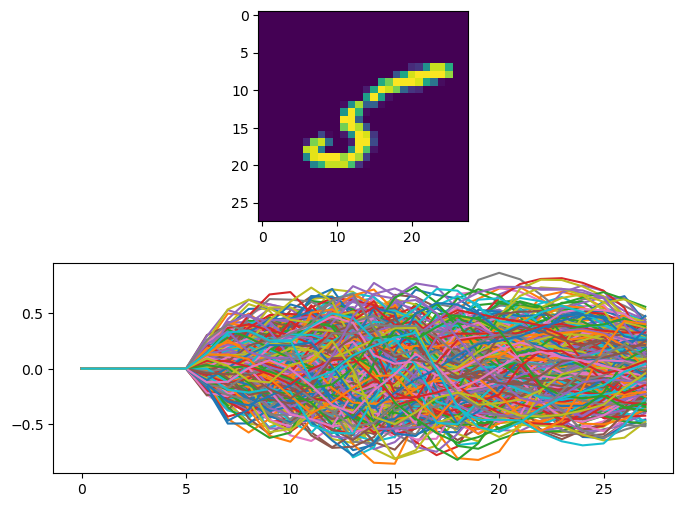

In [7]:
## Example of Response

fig, axs = plt.subplots(2, figsize=(8, 6))

image_n=11

axs[0].imshow(X_tr[image_n,:,:].cpu())

for n in range(N):
    axs[1].plot(Z_tr[image_n,n,:].cpu())
    

## Training from ESN response

First, notice how this is possible if the dynamics of the ESN is not subjected to adaptation.

The learning is based on the class Classification_Readouts, which takes the number of features N (not necessarily the number of nodes), the number of classes and the batch_size. From this class, it will be possible to train with online learning or with SpaRCe the output read-out. Training with Ridge-Regression is not included, but it is available upon request.



In [8]:
class Classification_ReadOuts:
    
    def __init__(self,N,N_class,device):
        
        self.N=N
        self.N_class=N_class
        self.device = device # add device as class attribute
                                
        self.Ws=[]
        self.theta_g=[]
        self.theta_i=[]
        self.Pn=[]
        
        self.loss=[]
        self.opt=[]
        self.opt_theta=[]        
    
    def Initialise_Online(self,alpha_size):
            
        self.Ws=nn.Parameter( (2*torch.rand([self.N,self.N_class], device=self.device)-1)/(self.N/10) )
        self.opt=optim.Adam([{'params': self.Ws, 'lr':alpha_size }])
        
        
    def Online_Step(self,state,y_true):
        
        state = state.to(self.device)
        y_true = y_true.to(self.device)
        
        loss = nn.BCEWithLogitsLoss()
            
        y=torch.matmul(state,self.Ws) 

        error=loss(y,y_true)
        error.backward()

        self.opt.step()
        self.opt.zero_grad()
            
        return y, error
    
    
    def Online_Evaluate(self,State,y_true):
        
        State = State.to(self.device)
        y_true = y_true.to(self.device)
        
        with torch.no_grad():
            
            loss = nn.BCEWithLogitsLoss()

            y=torch.matmul(State,self.Ws)

            error=loss(y,y_true)
            Acc=torch.mean( torch.eq(torch.argmax(y,dim=1),torch.argmax(y_true,dim=1)).float() )

        return y, Acc, error
    
    def Initialise_SpaRCe(self,X_tr,Pn,alpha_size,center=False):
        self.Pn=Pn/100

        self.loss = nn.BCEWithLogitsLoss()

        self.theta_g=torch.quantile(torch.abs(X_tr.cpu()),self.Pn,0).to(self.device)

        self.theta_i=nn.Parameter(torch.zeros([self.N], device=self.device))

        self.Ws=nn.Parameter( (2*torch.rand([self.N,self.N_class], device=self.device)-1)/(self.N/10) )

        self.opt=optim.Adam([{'params': self.Ws, 'lr':alpha_size },{'params': self.theta_i, 'lr':alpha_size/10 }])

    
    
    def SpaRCe_Step(self,state,y_true):
        
        state = state.to(self.device)
        y_true = y_true.to(self.device)
        
        loss = nn.BCEWithLogitsLoss()
            
        state_sparse=torch.sign(state)*torch.relu(torch.abs(state)-self.theta_g-self.theta_i)     

        y=torch.matmul(state_sparse,self.Ws)

        error=loss(y,y_true)

        error.backward()

        self.opt.step()
        self.opt.zero_grad()
    
        return y, error
    
    def SpaRCe_Evaluate(self,State,y_true, Return_S=False):
        
        State = State.to(self.device)
        y_true = y_true.to(self.device)
        
        with torch.no_grad():
            
            if Return_S==True:
                state_sparse=torch.zeros([State.size()[0],self.N])
            else:
                state_sparse=False

            loss = nn.BCEWithLogitsLoss()

            N_cl=torch.sum(State!=0)        

            state_sparse=torch.sign(State)*torch.relu(torch.abs(State)-self.theta_g-self.theta_i)
            
            y=torch.matmul(state_sparse,self.Ws)
            
            error=loss(y,y_true)

            Acc=torch.mean( torch.eq(torch.argmax(y,dim=1),torch.argmax(y_true,dim=1)).float() )

            sparsity=torch.sum(state_sparse!=0)/N_cl

        
        return y, Acc, error, sparsity, state_sparse

    def Get_Representation(self, State):
        State = State.to(self.device)
        with torch.no_grad():
            state_sparse = torch.sign(State)*torch.relu(torch.abs(State) - self.theta_g - self.theta_i)
        return state_sparse



In [9]:
# Reshape of the datasets and concatenation of the responses across time. In this way, we use a different output weight for each 
# node AND time step, resulting in a number of features equal to N*T.
Z_tr=torch.reshape(Z_tr,[Z_tr.size()[0],N*T]).to(device)
Z_val=torch.reshape(Z_val,[Z_val.size()[0],N*T]).to(device)
Z_te=torch.reshape(Z_te,[Z_te.size()[0],N*T]).to(device)

mean=Z_tr.mean(axis=0)
Z_tr-=mean
Z_val-=mean
Z_te-=mean

batch_size=200  
alpha_size=0.005 #learning rate
initial_sparsity_level=70 # percentage, e.g., 50%: it corresponds to a percentile

Mod=Classification_ReadOuts(N*T,N_o,device) # Notice how the input is the number of features

SpaRCe=True
if SpaRCe==True:
    Mod.Initialise_SpaRCe(Z_tr,initial_sparsity_level,alpha_size)
    
else:
    alpha_size=0.001
    
    Mod.Initialise_Online(alpha_size)


In [10]:
sparse_representation = Mod.Get_Representation(Z_tr)
sparse_representation_np = sparse_representation.detach().cpu().numpy()

# Save the sparse_representationnumpy array to a file
np.save('sparse_representation.npy', sparse_representation_np)

##  Training 



In [11]:
N_batch=20000   ## Total Number of minibatches used to train
N_check=10
N_checks=np.arange(0,N_check+1)*int(np.floor(N_batch/N_check)) ## Instances at which we evaluate

ACC=np.zeros([2,N_check])  ## Placeholder for accuracy (Validation and testing) across training 
CL=np.zeros([2,N_check])   ## Placeholder for 1-sparsity (Validation and testing) across training 

index_help=0

for n in range(N_batch):

    rand_ind=np.random.randint(0,np.shape(Z_tr)[0],(batch_size,))

    state=torch.clone(Z_tr[rand_ind,:]).to(device)

    labels=torch.clone(Y_tr[rand_ind,:]).to(device)

    if n>0:
        if SpaRCe==True:
            y, error=Mod.SpaRCe_Step(state,labels)
        else:
            y, error=Mod.Online_Step(state,labels)

    if n==N_checks[index_help]:
        images_te=torch.clone(Z_te[:,:]).to(device)
        labels_te=torch.clone(Y_te[:,:]).to(device)
        images_val=torch.clone(Z_val[:,:]).to(device)
        labels_val=torch.clone(Y_val[:,:]).to(device)

        if SpaRCe==True:
            Out_te, Acc_te, Error_te, Sp_te, State_sp_te=Mod.SpaRCe_Evaluate(images_te,labels_te)
            Out_val, Acc_val, Error_val, Sp_val, State_sp_val=Mod.SpaRCe_Evaluate(images_val,labels_val)
            CL[0,index_help]=np.copy(Sp_val.detach().cpu().numpy())
            CL[1,index_help]=np.copy(Sp_te.detach().cpu().numpy())
        else:
            Out_te, Acc_te, Error_te=Mod.Online_Evaluate(images_te,labels_te)
            Out_val, Acc_val, Error_val=Mod.Online_Evaluate(images_val,labels_val)

        ACC[0,index_help]=np.copy(Acc_val.detach().cpu().numpy())
        ACC[1,index_help]=np.copy(Acc_te.detach().cpu().numpy())
        if SpaRCe==True:            
            print('Iteration: ',n,'SpaRCe ','VAL: ', Acc_val.detach().cpu().numpy(),
            'TE: ', Acc_te.detach().cpu().numpy(), 'Error: ',Error_val.detach().cpu().numpy(), Error_te.detach().cpu().numpy(), 'Coding ',Sp_val.cpu().numpy(), Sp_te.cpu().numpy())
        else:
            print('Iteration: ',n,'RC ','VAL: ', Acc_val.detach().cpu().numpy(),
            'TE: ', Acc_te.detach().cpu().numpy(), 'Error: ',Error_val.detach().cpu().numpy(), Error_te.detach().cpu().numpy())

        index_help=index_help+1


Iteration:  0 SpaRCe  VAL:  0.1205 TE:  0.1235 Error:  0.69308025 0.6930667 Coding  0.24982952 0.24854
Iteration:  2000 SpaRCe  VAL:  0.9756 TE:  0.9734 Error:  0.020755747 0.021041764 Coding  0.301165 0.30038765
Iteration:  4000 SpaRCe  VAL:  0.97779995 TE:  0.9756 Error:  0.020172916 0.019879196 Coding  0.30367553 0.30295795
Iteration:  6000 SpaRCe  VAL:  0.9777 TE:  0.9759 Error:  0.022192182 0.022776881 Coding  0.30789977 0.3072497
Iteration:  8000 SpaRCe  VAL:  0.9776 TE:  0.9755 Error:  0.023501504 0.023315214 Coding  0.2988408 0.29827037
Iteration:  10000 SpaRCe  VAL:  0.9788 TE:  0.97709996 Error:  0.024274679 0.023440365 Coding  0.29779392 0.2972486
Iteration:  12000 SpaRCe  VAL:  0.9777 TE:  0.97669995 Error:  0.026132166 0.02508213 Coding  0.29404724 0.29356772
Iteration:  14000 SpaRCe  VAL:  0.97859997 TE:  0.977 Error:  0.027456865 0.026487809 Coding  0.28231525 0.28183976
Iteration:  16000 SpaRCe  VAL:  0.9788 TE:  0.97749996 Error:  0.0280508 0.027213933 Coding  0.287474

In [12]:
end = time.time()
print(f"Time taken on CPU+GPU: {end - start} seconds")

Time taken on CPU+GPU: 155.3990342617035 seconds


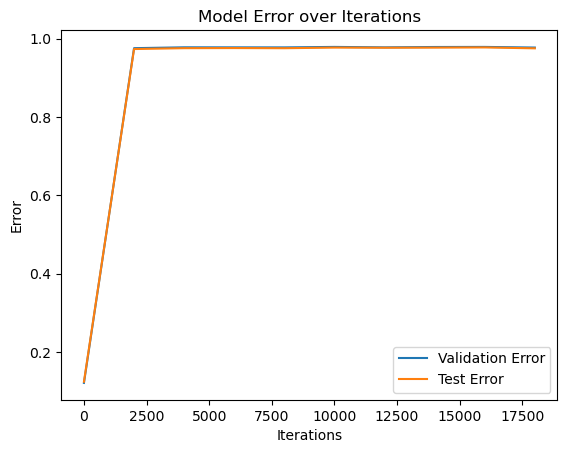

In [13]:
import matplotlib.pyplot as plt

iterations = np.arange(0, N_batch, N_batch/N_check) # create an array for the x-axis (iterations)
error_val = ACC[0, :] # errors for validation set
error_te = ACC[1, :] # errors for test set

# plot validation error
plt.plot(iterations, error_val, label='Validation Error')
# plot test error
plt.plot(iterations, error_te, label='Test Error')

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Model Error over Iterations')
plt.legend()
plt.show()


In [14]:
final_representation = Mod.Get_Representation(Z_tr)
final_representation_np = final_representation.detach().cpu().numpy()

# Save the final_representation array to a file
np.save('final_representation.npy', final_representation_np)

# Convert Z_tr to CPU and numpy array
Z_tr_np = Z_tr.detach().cpu().numpy()

# Save Z_tr array to a file
np.save('Z_tr.npy', Z_tr_np)

# Get the shape of the final_representation array
shape = final_representation_np.shape

# Interpret the dimensions
num_samples = shape[0]
num_features = shape[1]

# Print the interpretation
print("Number of samples:", num_samples)
print("Number of features:", num_features)

Number of samples: 50000
Number of features: 14000


In [15]:
print("Number of training data points:", N_tr)

Number of training data points: 50000


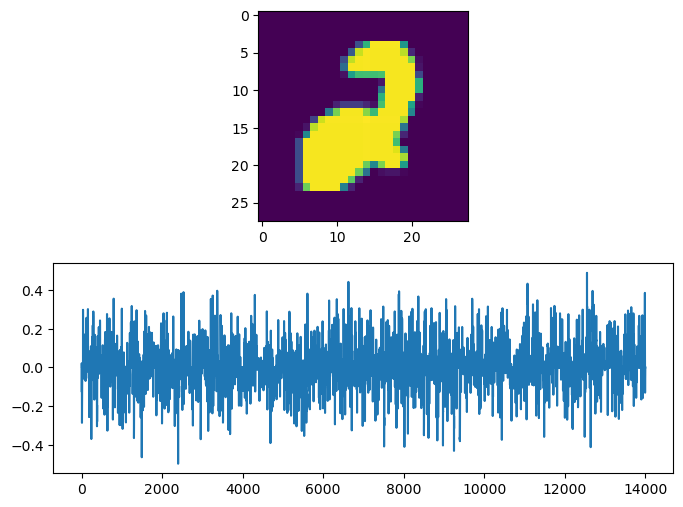

In [16]:
fig, axs = plt.subplots(2, figsize=(8, 6))

image_n = 5000

# Convert the image tensor to CPU and numpy
image_np = X_tr[image_n, :, :].cpu().numpy()

# Plot the image
axs[0].imshow(image_np)

# Plot the final representation
axs[1].plot(final_representation[image_n, :].cpu())

plt.show()